In [1]:
import numpy as np
import lightgbm as lgb
import pandas as pd
import seaborn as sns

from datetime import timedelta
from tqdm.notebook import tqdm
import time
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt
import pickle

# Model training 

In [83]:
fl_df=pd.read_csv('data/fl_hourly_20200101_20240205_GGL_NVD_MS_APL.csv')
fl_df.timestamp=pd.to_datetime(fl_df.timestamp, utc=True)
fl_df=fl_df.set_index('timestamp')
fl_df=fl_df.drop(columns='Unnamed: 0')

categorical=['symbol']
with open('models/all_features20240207.pkl', 'rb') as f:
    feature_columns=pickle.load(f)
#feature_columns.remove('label')

feature_columns=feature_columns+['symbol']


fl_df.index.min(),fl_df.index.max()

(Timestamp('2020-01-02 09:00:00+0000', tz='UTC'),
 Timestamp('2024-02-05 19:00:00+0000', tz='UTC'))

In [84]:
fl_minute=pd.read_csv('bars_minute_20200101_GGL_NVD_MS_APL.csv').drop(columns='Unnamed: 0')
fl_minute['timestamp']=pd.to_datetime(fl_minute.timestamp, utc=True)
fl_minute=fl_minute.drop(columns=['last_value_open','last_value_high','last_value_low','last_value_close','last_value_volume','last_value_trade_count','last_value_vwap','last_value_delta_HL','last_value_nrmlz_open','last_value_nrmlz_high','last_value_nrmlz_low','last_value_nrmlz_close','last_value_nrmlz_volume','last_value_nrmlz_trade_count','last_value_nrmlz_vwap','last_value_nrmlz_delta_HL'])

In [85]:
data=pd.merge(fl_df,fl_minute,on=['timestamp','symbol'],how='inner')

In [86]:
minute_features_list=fl_minute.columns.tolist()
minute_features_list.remove('timestamp_minute')
minute_features_list.remove('timestamp')
minute_features_list.remove('symbol')

In [87]:
for cat in categorical:
    data[cat]=data[cat].astype("category")

In [88]:
train_test_split_date=pd.to_datetime('2023-09-01').tz_localize('UTC')

train=data[data.timestamp<train_test_split_date]
test=data[data.timestamp>=train_test_split_date]


#the step above messe up the timestamp orders because it's using set, below sorts it out
train=train.sort_values(by=['timestamp','symbol']).set_index('timestamp')
test=test.sort_values(by=['timestamp','symbol']).set_index('timestamp')

## set params of timeseries cross-validation

In [89]:
train_period_in_months=round((train.index.max()-train.index.min())/np.timedelta64(1, 'M'))

internal_validation_split_in_months=3
stride_in_month=2
cv_splits=10

internal_training_split_in_months=train_period_in_months-(cv_splits-1)*stride_in_month-internal_validation_split_in_months
print('internal_training_split_in_months will be: '+str(internal_training_split_in_months))

internal_training_split_in_months will be: 22


In [90]:
internal_training_startdate=train.index.min()
train.index.min(),train.index.max()

(Timestamp('2020-01-02 09:00:00+0000', tz='UTC'),
 Timestamp('2023-08-31 23:00:00+0000', tz='UTC'))

In [91]:
feature_columns=feature_columns+minute_features_list
params={'importance_type':'gain','boosting_type':'dart'}

feature_importances=np.zeros([cv_splits,len(feature_columns)])

for fold,tscv_index_time in enumerate([train.index.min()+np.timedelta64(internal_training_split_in_months, 'M')+np.timedelta64(i*stride_in_month, 'M') for i in range(cv_splits)]):
    internal_tscv_split_training_starttime=internal_training_startdate+np.timedelta64(fold*stride_in_month, 'M')
    internal_tscv_split_validation_endtime=tscv_index_time+np.timedelta64(internal_validation_split_in_months, 'M')

    
    print('fold {}: training [{},  {}]   testing [{},  {}]'.format(fold,
                                             internal_tscv_split_training_starttime.date().strftime("%Y-%m-%d"),
                                             tscv_index_time.date().strftime("%Y-%m-%d"),
                                             tscv_index_time.date().strftime("%Y-%m-%d"),
                                             internal_tscv_split_validation_endtime.date().strftime("%Y-%m-%d") ))

    #train model
    tscv_train_indices=(train.index<tscv_index_time) & (train.index>=internal_tscv_split_training_starttime)
    tscv_validation_indices=(train.index>=tscv_index_time) & (train.index<=internal_tscv_split_validation_endtime)

    clf = lgb.LGBMClassifier(**params)
    clf.fit(train[tscv_train_indices][feature_columns], train[tscv_train_indices]['label'],categorical_feature=['symbol'])

    feature_importances[fold,:]=clf.feature_importances_



fold 0: training [2020-01-02,  2021-11-01]   testing [2021-11-01,  2022-01-30]


/opt/anaconda3/envs/hft/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


fold 1: training [2020-03-01,  2021-12-30]   testing [2021-12-30,  2022-03-30]


/opt/anaconda3/envs/hft/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


fold 2: training [2020-05-01,  2022-03-01]   testing [2022-03-01,  2022-05-30]


/opt/anaconda3/envs/hft/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


fold 3: training [2020-07-01,  2022-05-01]   testing [2022-05-01,  2022-07-30]


/opt/anaconda3/envs/hft/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


fold 4: training [2020-09-01,  2022-07-02]   testing [2022-07-02,  2022-09-30]


/opt/anaconda3/envs/hft/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


fold 5: training [2020-11-01,  2022-09-01]   testing [2022-09-01,  2022-11-30]


/opt/anaconda3/envs/hft/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


fold 6: training [2021-01-01,  2022-11-01]   testing [2022-11-01,  2023-01-30]


/opt/anaconda3/envs/hft/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


fold 7: training [2021-03-01,  2022-12-30]   testing [2022-12-30,  2023-03-30]


/opt/anaconda3/envs/hft/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


fold 8: training [2021-05-01,  2023-03-01]   testing [2023-03-01,  2023-05-30]


/opt/anaconda3/envs/hft/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


fold 9: training [2021-07-01,  2023-05-01]   testing [2023-05-01,  2023-07-30]


/opt/anaconda3/envs/hft/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


<Axes: xlabel='mean_importance', ylabel='Feature'>

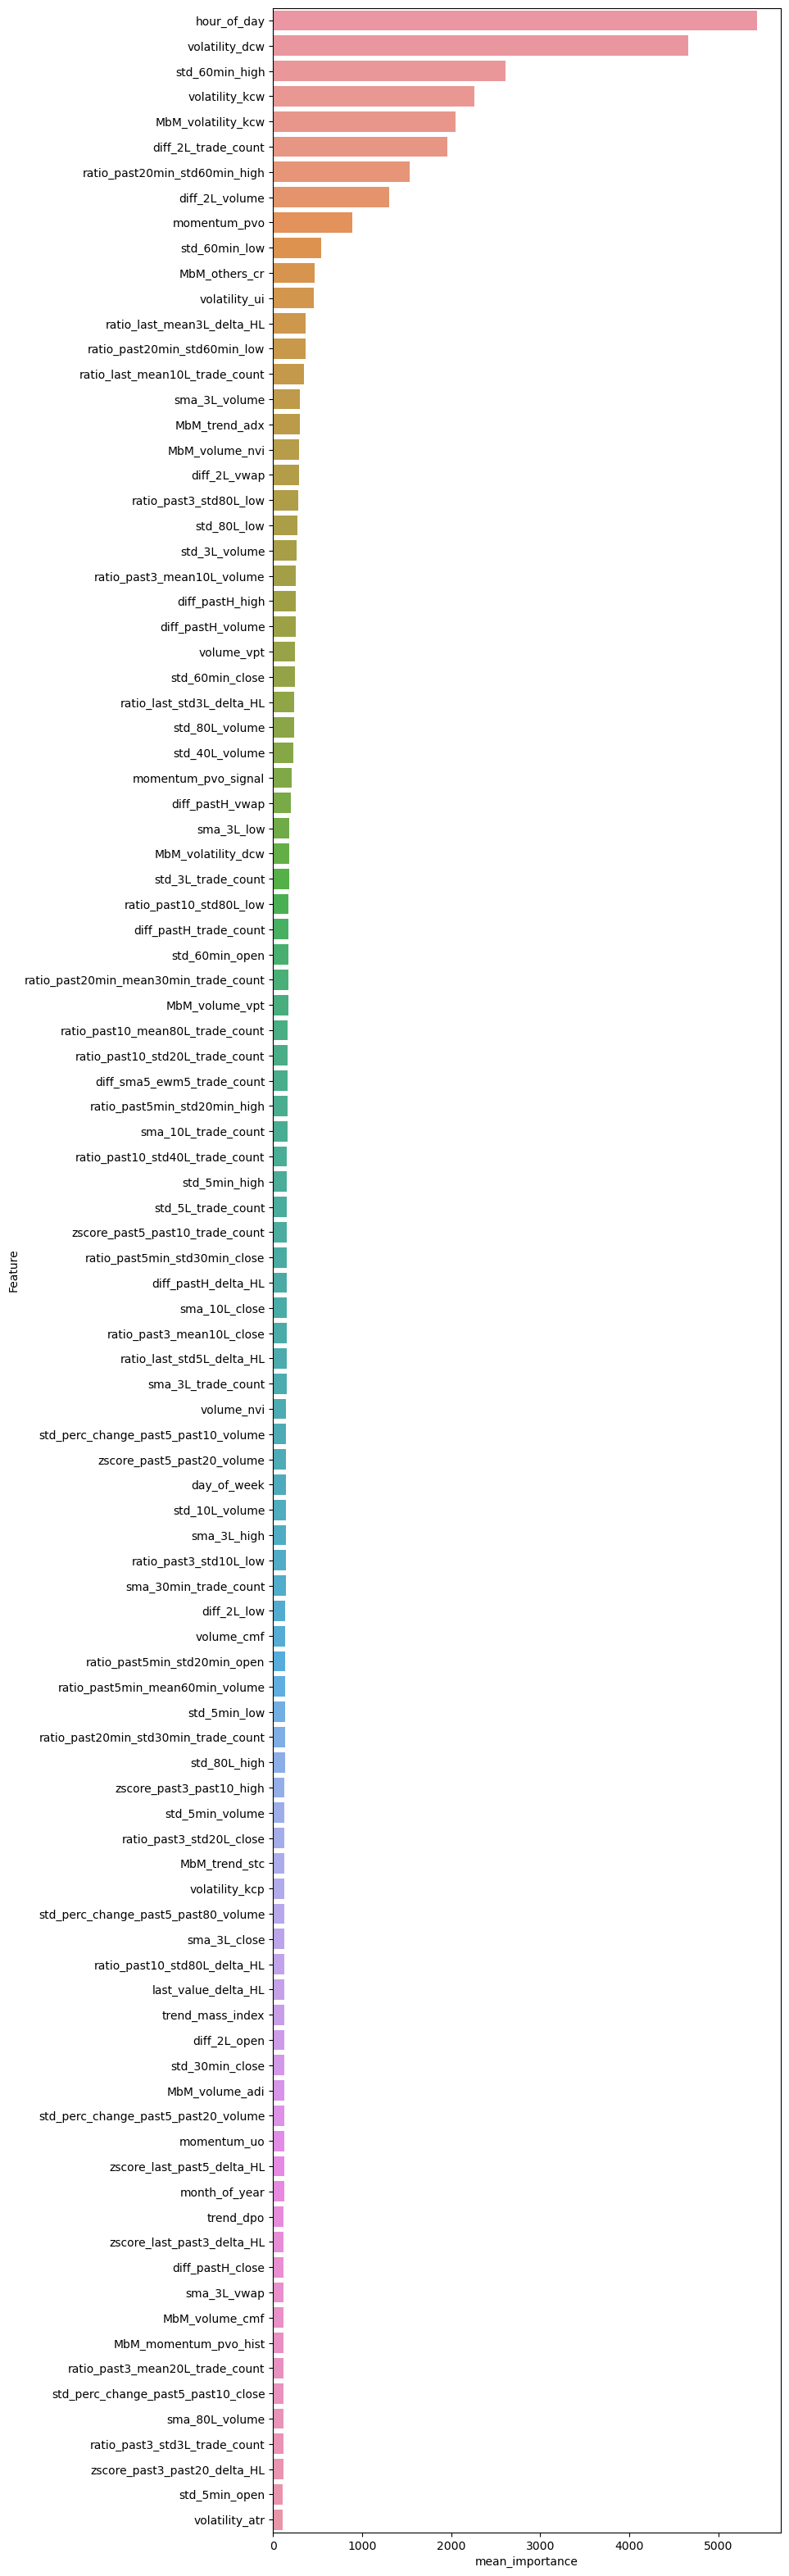

In [92]:
feature_imp=pd.DataFrame(zip(feature_importances.mean(axis=0),feature_importances.mean(axis=0)-1*feature_importances.std(axis=0)),columns=['mean_importance','lower_bound_importance'],index=feature_columns)
feature_imp=feature_imp.sort_values(by='mean_importance',ascending=False).reset_index().rename(columns={'index':'Feature'})

selected_features=feature_imp[feature_imp['lower_bound_importance']>0]['Feature'].tolist()

plt.figure(figsize=(8,40))
sns.barplot(x='mean_importance',y='Feature',data=feature_imp.iloc[0:100])

In [106]:
selected_features

['hour_of_day',
 'volatility_dcw',
 'std_60min_high',
 'volatility_kcw',
 'MbM_volatility_kcw',
 'diff_2L_trade_count',
 'ratio_past20min_std60min_high',
 'diff_2L_volume',
 'momentum_pvo',
 'std_60min_low',
 'MbM_others_cr',
 'volatility_ui',
 'ratio_last_mean3L_delta_HL',
 'ratio_last_mean10L_trade_count',
 'sma_3L_volume',
 'MbM_trend_adx',
 'MbM_volume_nvi',
 'diff_2L_vwap',
 'ratio_past3_std80L_low',
 'std_80L_low',
 'std_3L_volume',
 'diff_pastH_high',
 'diff_pastH_volume',
 'volume_vpt',
 'ratio_last_std3L_delta_HL',
 'std_40L_volume',
 'momentum_pvo_signal',
 'diff_pastH_vwap',
 'sma_3L_low',
 'MbM_volatility_dcw',
 'std_3L_trade_count',
 'diff_pastH_trade_count',
 'ratio_past20min_mean30min_trade_count',
 'MbM_volume_vpt',
 'ratio_past10_mean80L_trade_count',
 'ratio_past10_std20L_trade_count',
 'diff_sma5_ewm5_trade_count',
 'ratio_past5min_std20min_high',
 'sma_10L_trade_count',
 'ratio_past10_std40L_trade_count',
 'std_5min_high',
 'std_5L_trade_count',
 'zscore_past5_past1

# train final model

In [93]:
len(selected_features)

574

In [94]:
'symbol' in selected_features

False

In [105]:
train['high_next2']

timestamp
2020-01-02 09:00:00+00:00       NaN
2020-01-02 09:00:00+00:00       NaN
2020-01-02 09:00:00+00:00       NaN
2020-01-02 10:00:00+00:00    296.05
2020-01-02 10:00:00+00:00    159.19
                              ...  
2023-08-31 22:00:00+00:00    492.35
2023-08-31 23:00:00+00:00    188.32
2023-08-31 23:00:00+00:00    136.72
2023-08-31 23:00:00+00:00    328.67
2023-08-31 23:00:00+00:00    493.02
Name: high_next2, Length: 55281, dtype: float64

In [95]:
for df in [train,test]:
    for cat in categorical:
        df[cat]=df[cat].astype("category")

In [103]:
#selected_features.remove('volatility_dcw')
ns_probs = [0 for _ in range(test.shape[0])]
# fit a model
params={'importance_type':'gain','boosting_type':'dart'}
clf = lgb.LGBMClassifier(**params)
clf.fit(train[[feature for feature in feature_columns if feature in selected_features]], train['high_next2'])#, categorical_feature=['symbol']

ValueError: Input contains NaN.

In [104]:
# predict probabilities
model_probs = clf.predict_proba(test[[feature for feature in feature_columns if feature in selected_features]])[:, 1]
# calculate scores
ns_auc = roc_auc_score(test['label'], ns_probs)
model_auc = roc_auc_score(test['label'], model_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Model: ROC AUC=%.3f' % (model_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test['label'], ns_probs)
model_fpr, model_tpr, _ = roc_curve(test['label'], model_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(model_fpr, model_tpr, marker='.', label='model')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

NotFittedError: Estimator not fitted, call fit before exploiting the model.

In [98]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [99]:
test_scores=pd.concat([pd.Series(model_probs,index=test.index),test['symbol']],axis=1).rename(columns={0:'score'})

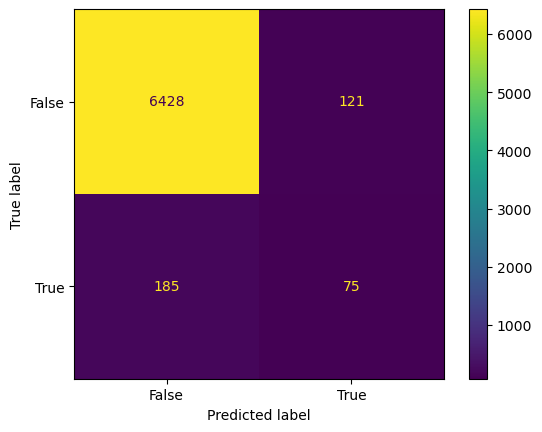

In [101]:
cm = confusion_matrix((test['label']), test_scores.score>0.3, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()

In [47]:
# ROC history: iteration 1: ROC AUC=0.809
# ROC history: iteration 2: ROC AUC=0.898 added 4 tech companies and data from 2020, added feature selection
# ROC history: iteration 2: ROC AUC=0.986 Normalised features added technical analysis
# ROC history: iteration 2: ROC AUC=0.999 with feature selection
# ROC history: iteration 2: ROC AUC=0.942 ewm was causing data leakage, removed it, dcw is suspecious!
# ROC history: iteration 3: ROC AUC=0.898 Added minute by minute indicators pertaining to the past hour. 